# U-NET model performance

We evaluate here a model with a layer depth of 3 and 16 filters in the first layer. It was trained with a patience of 3 epochs. It was trained with weighted binary losses of 0.5 for no hail and 463.21 for hail.

In [1]:
%matplotlib inline
import glob
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import unet
from unet import utils
from unet.datasets import circles
from copy import deepcopy
from sklearn.metrics import confusion_matrix

import inspect

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.3.0
GPU is NOT AVAILABLE


## Some global variables

In [2]:
datapath = '/data/ml_course/05_Capstone_project/dl_data/'
modelpath = './unet_models/unet_ld3_fr16_p6'
flist_name = './unet_models/unet_ld3_fr16_p6_flist.npz'
hist_name = './unet_models/unet_ld3_fr16_p6_history.pickle'

# parameters for evaluation
pred_batch_size = 4

## Auxiliary functions

In [3]:
def read_data(fname):
    """
    Reads features and labels stored in npz files
    
    Parameters
    ----------
    fname : str
        path of the file containing the data
        
    Returns
    -------
    X : float array 
        features matrix of size nx, ny, nchannels
    y : float array
        lables matrix of size, nx, ny, nclasses
    
    """
    with np.load(fname, allow_pickle=False) as npz_file:
        # Load the arrays
        X = npz_file['features']
        y = npz_file['targets']
    return X, y

In [4]:
def data_generator(file_list, stop_at_end=False):
    """
    data generator
    
    Parameters
    ----------
    file_list : list of str
        lists of files where the data is stored
    stop_at_end : bool
        Controls the behaviour when running out of files.
        If True exits the function. Otherwise reshuffles the list
        and sets the counter to 0
    
    Yield
    -------
    X : float array 
        features matrix of size nx, ny, nchannels
    y : float array
        lables matrix of size, nx, ny, nclasses
    
    """
    i = 0
    while True:
        if i >= len(file_list):
            if stop_at_end:
                break
            i = 0
            np.random.shuffle(file_list)            
        else:
            X, y = read_data(file_list[i])            
            yield X, y
            i = i + 1

In [5]:
def get_dataset(flist, stop_at_end=False):
    """
    Creates a tensorflow dataset from a generator
    
    Parameters
    ----------
    file_list : list of str
        lists of files where the data is stored
    stop_at_end : bool
        Controls the behaviour when running out of files.
        If True exits the function. Otherwise reshuffles the list
        and sets the counter to 0
    
    Returns
    -------
    dataset : tf.data.Dataset
        A dataset containing the features and labels
    
    """
    X, y = read_data(flist[0])
    nx = X.shape[0]
    ny = X.shape[1]
    nchannels = X.shape[2]
    nclasses = y.shape[2]
    return tf.data.Dataset.from_generator(
        data_generator, args=[flist, stop_at_end], output_types=(tf.float32, tf.float32),
        output_shapes = ((nx, ny, nchannels), (nx, ny, nclasses)))

## Load and show training history

In [6]:
with open(hist_name, "rb") as input_file:
     history = pickle.load(input_file)

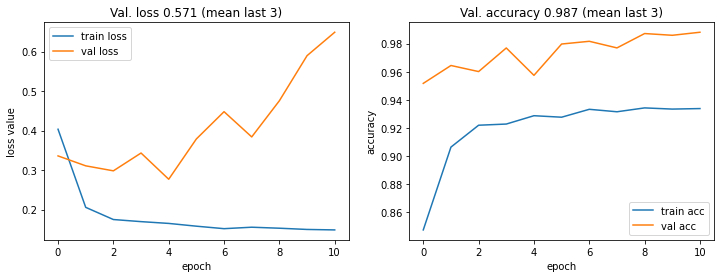

In [7]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history['loss'], label='train loss')
ax1.plot(history['val_loss'], label='val loss')
ax1.set_title('Val. loss {:.3f} (mean last 3)'.format(
    np.mean(history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history['binary_accuracy'], label='train acc')
ax2.plot(history['val_binary_accuracy'], label='val acc')
ax2.set_title('Val. accuracy {:.3f} (mean last 3)'.format(
    np.mean(history['val_binary_accuracy'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()

## Plot accuracy values
#ax3.plot(history.history['dice_coefficient'], label='train acc')
#ax3.plot(history.history['val_dice_coefficient'], label='val acc')
#ax3.set_title('Val. dice coeff {:.3f} (mean last 3)'.format(
#    np.mean(history.history['val_dice_coefficient'][-3:]) # last three values
#))
#ax3.set_xlabel('epoch')
#ax3.set_ylabel('accuracy')
#ax3.legend()

plt.show()

The validation losses keep increasing.

## Load test data

In [8]:
# load the file list
with np.load(flist_name, allow_pickle=False) as npz_file:
    flist_te_aux=npz_file['flist_te']
nfiles_te = len(flist_te_aux)
print('Number of test files:', nfiles_te)

Number of test files: 351


In [9]:
flist_te = []
for fname in flist_te_aux:
    flist_te.append(datapath+os.path.basename(fname))

In [10]:
test_dataset = get_dataset(flist_te, stop_at_end=True) # Put to stop at end because there is no stopping mechanism in the u-net evaluation

## Load model

In [11]:
unet_model = tf.keras.models.load_model(modelpath, compile=False)

## Make predictions

In [12]:
prediction = unet_model.predict(test_dataset.batch(pred_batch_size), verbose=1, steps=int(nfiles_te/pred_batch_size))

87/87 [==============================] - 68s 786ms/step


In [13]:
dataset = test_dataset.map(utils.crop_image_and_label_to_shape(prediction.shape[1:]))

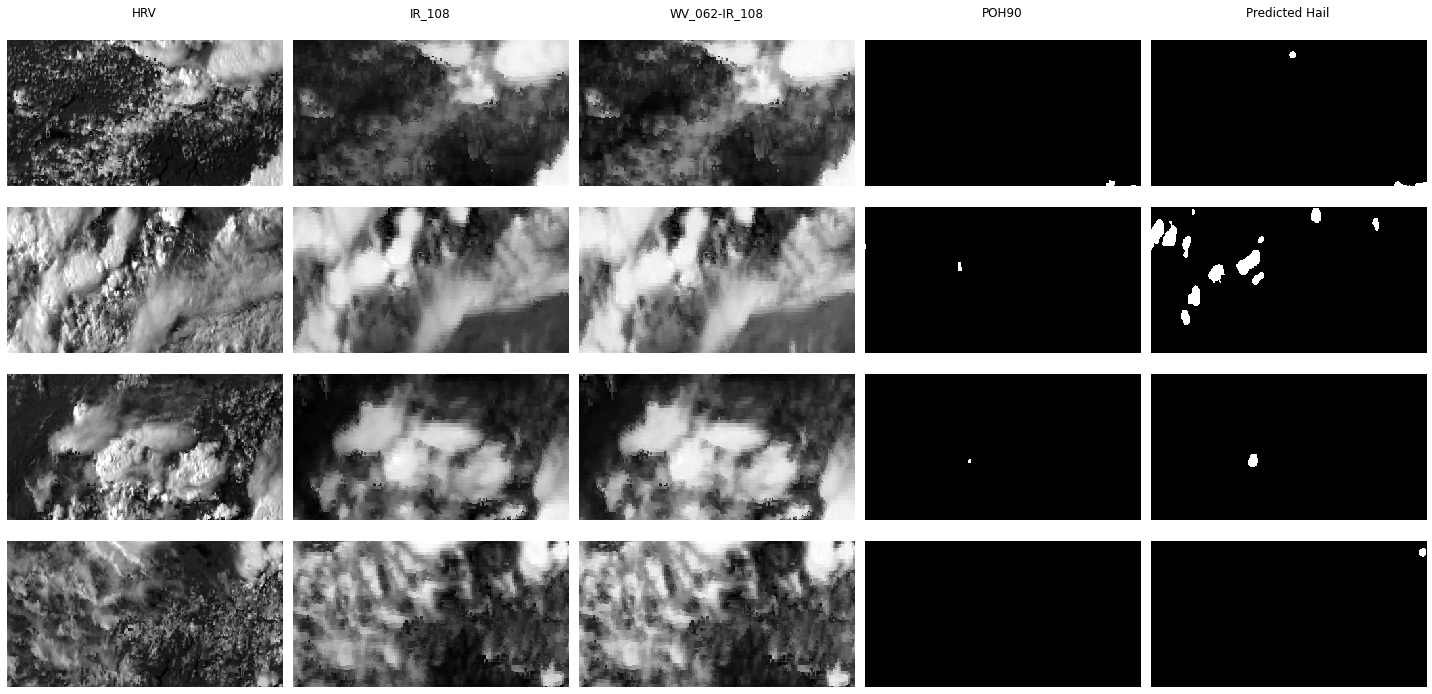

In [14]:
fig, ax = plt.subplots(4, 5, figsize=(20,10))
for i, (image, label) in enumerate(dataset.take(4)):
    hrv = image.numpy()[:, :, 0]
    ir = image.numpy()[:, :, 1]
    diff = image.numpy()[:, :, 2]
    
    lab = np.argmax(label, axis=-1)
    pred = np.argmax(prediction[i,...], axis=-1)
        
    ax[i][0].matshow(hrv.T[::-1, :], cmap=plt.cm.gray)
    ax[i][0].axis('off')
    ax[0][0].set_title('HRV')
    
    ax[i][1].matshow(ir.T[::-1, :], cmap=plt.cm.gray_r)
    ax[i][1].axis('off')
    ax[0][1].set_title('IR_108')
    
    ax[i][2].matshow(diff.T[::-1, :], cmap=plt.cm.gray)
    ax[i][2].axis('off')
    ax[0][2].set_title('WV_062-IR_108')
    
    ax[i][3].matshow(lab.T[::-1, :], cmap=plt.cm.gray)
    ax[i][3].axis('off')
    ax[0][3].set_title('POH90')
    
    ax[i][4].matshow(pred.T[::-1, :], cmap=plt.cm.gray)
    ax[i][4].axis('off')
    ax[0][4].set_title('Predicted Hail')
    
plt.tight_layout()

It should be noticed that due to the fact that there is no padding applied the margins of the image are cropped. The model does show some skill in locating hail although it overestimates its extend

## Evaluate model

We manually compute the confusion matrix over the test dataset

In [15]:
tn = 0
fp = 0
fn = 0
tp = 0

positive = 0
negative = 0
for i, (image, label) in enumerate(dataset.take(prediction.shape[0])):
    lab = np.argmax(label, axis=-1)
    pred = np.argmax(prediction[i,...], axis=-1)
    
    tn_aux, fp_aux, fn_aux, tp_aux = confusion_matrix(lab.flatten(), pred.flatten(), labels=[0, 1]).ravel()
    
    tn += tn_aux
    fp += fp_aux
    fn += fn_aux
    tp += tp_aux
    
    positive += lab[lab == 1].size
    negative += lab[lab == 0].size
    
print('True positive: ', tp)
print('True negative: ', tn)
print('False positive: ', fp)
print('False negative: ', fn)
print('Positive pixels: ', positive)
print('Negative pixels: ', negative)

True positive:  19641
True negative:  30279352
False positive:  358794
False negative:  10757
Positive pixels:  30398
Negative pixels:  30638146


In [16]:
pod = 100*tp/(tp+fn)
far = 100*fp/(fp+tn)
ppv = tp/(tp+fp)
print('Probability of Detection (POD):', pod)
print('False Alarm Rate (FAR):', far)
print('Positive Predictive Value (PPV):', ppv)

Probability of Detection (POD): 64.61280347391276
False Alarm Rate (FAR): 1.1710695549267243
Positive Predictive Value (PPV): 0.05190059059019383


Increasing the patience does not have any noticeable positive impact on the results of the model